Troubleshooting pointcounts.

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
from shapely.geometry import Polygon

In [2]:
def scopeCountsInAreas(countname, ncounts_df, area_gdf):
    # read counts per station, with point locations
    ncounts_gdf = gpd.GeoDataFrame(ncounts_df,
                                   geometry = gpd.points_from_xy(ncounts_df.stop_lon, ncounts_df.stop_lat),
                                   crs="epsg:4326").to_crs("epsg:4326")
    ## get sum of stuff in each AGS
    agg_counts_df = gpd.sjoin(area_gdf[["AGS","geometry"]], ncounts_gdf[["n_day","geometry"]], how="left", op="contains" # spatial join
                        )[["AGS","n_day"]
                        ].groupby("AGS").sum().rename({"n_day":countname},axis=1
                        ) # keep AGS that have counts in them
    return(agg_counts_df)

In [3]:
def make_grid(scale, stopspace):   
    # scale is a sidelength in km
    # stopspace is a Geodataframe containing the complex hull of the space to be covered with grid, IN EPSG:3035
    print("Making grid with sidelength "+ str(scale) + "km")
    # iterate little boxes with sidelength sl:
    bounds = stopspace.total_bounds
    xmin,ymin,xmax,ymax =  bounds
    slm = scale*1000 # m
    rows = int(np.ceil((ymax-ymin) /  slm)) 
    cols = int(np.ceil((xmax-xmin) / slm))  
    print(str(rows) + " x " + str(cols))
    XleftOrigin = xmin
    XrightOrigin = xmin + slm
    YtopOrigin = ymax
    YbottomOrigin = ymax- slm
    polygons = []
    for i in range(cols):
        Ytop = YtopOrigin
        Ybottom =YbottomOrigin
        for j in range(rows):
            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
            Ytop = Ytop - slm
            Ybottom = Ybottom - slm
        XleftOrigin = XleftOrigin + slm
        XrightOrigin = XrightOrigin + slm
    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = 'epsg:3035'
    grid = grid[~gpd.sjoin(grid, stopspace, how='left', op='intersects')["index_right"].isna()] # choose squares that overlap with convex hull
#    grids[scale] = grid                                                             # either save all the grids in a dict...    # or save them to file--if it gets big that may be better
    return(grid)

In [4]:
def aggregateGrid(grid, ncounts_gdf):
    print("Getting counts for grid with " + str(len(grid)) + " polygons")
#    agg_counts_gdf = grids[scale] # or if this gets too unwieldy load from disk...
    agg_counts_gdf = grid.to_crs('epsg:4326')
    ### !!! I'm worried we might lose shapes here, if they don't have one of the type of counts. Maybe better to keep them separate (like above)
    ## get sum of stuff in each AGS
    agg_counts_gdf = gpd.sjoin(agg_counts_gdf, ncounts_gdf[["n_day","geometry"]], how="left", op="contains" # spatial join
                        ).drop("index_right",axis=1).reset_index().dissolve(by="index",aggfunc='sum').rename({"n_day":"n"},axis=1)
    agg_counts_gdf = agg_counts_gdf[agg_counts_gdf['n']>0]
    return(agg_counts_gdf)

In [5]:
# Welche Pfade?
out_dir = "/home/maita/Nextcloud/Documents/Work/Gap_Map/out/Brosi/2021/"
pointfile = out_dir + "2021_reissue_2.nstops.csv"

In [6]:

points = pd.read_csv(pointfile, nrows=50000)

In [7]:
points_gdf = gpd.GeoDataFrame(points,
                                       geometry = gpd.points_from_xy(points.stop_lon, points.stop_lat),
                                       crs="epsg:4326").to_crs("epsg:4326")

<AxesSubplot:>

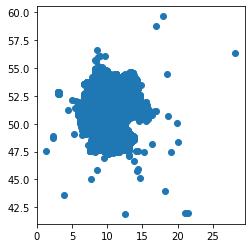

In [8]:
points_gdf.plot()

In [9]:
stopspace = gpd.GeoDataFrame({'geometry':[points_gdf.to_crs("epsg:3035").unary_union.convex_hull]}, crs="epsg:3035")
grid_500 = make_grid(500, stopspace)
grid_50 = make_grid(50, stopspace)

grid_1 = make_grid(1, stopspace)

Making grid with sidelength 500km
4 x 4
Making grid with sidelength 50km
40 x 36
Making grid with sidelength 1km
1993 x 1762


### This is important! the to_crs for the counts gdf wasn' t there before, maybe that was the whole problem??

<AxesSubplot:>

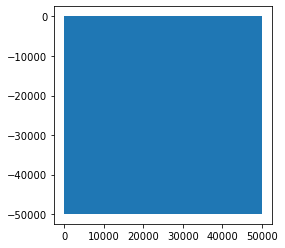

In [55]:
grid_50.plot()

In [13]:
counts_500 = aggregateGrid(grid_500, points_gdf) 

Getting counts for grid with 16 polygons


In [14]:
counts_50 = aggregateGrid(grid_50, points_gdf)

Getting counts for grid with 1122 polygons


In [15]:
counts_1 = aggregateGrid(grid_1, points_gdf)

Getting counts for grid with 2619392 polygons


In [16]:
points_gdf.n_day.sum()

729162.9008498583

In [17]:
counts_50.n.sum()

729162.7167138809

In [18]:
counts_500.n.sum()

729162.7167138811

In [19]:
counts_1.n.sum()

729162.716713881

In [83]:
gpd.read_file(out_dir + "2021_reissue_2_5k.stops.4326.geojson",driver="GeoJSON").sum(0)

index    4.670684e+08
n.all    4.130571e+09
n.fv     1.006314e+04
dtype: float64

In [84]:
gpd.read_file(out_dir + "2021_reissue_2_1k.stops.4326.geojson",driver="GeoJSON").sum(0)

index    8.530216e+10
n.all    3.474612e+08
n.fv     1.006314e+04
dtype: float64

In [ ]:
pd.read_csv(pointfile).sum(0)